In [1]:
#导入包

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns;sns.set_style('whitegrid')
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
#导入数据

train_data = pd.read_csv('D:\\Py_dataset\\train.csv')
test_data = pd.read_csv('D:\\Py_dataset\\test.csv')

#查看训练集与测试集的规模
print('训练集的大小:',train_data.shape)
print('测试集的大小:',test_data.shape)

训练集的大小: (891, 12)
测试集的大小: (418, 11)


### 1：总览数据

In [3]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


**特征说明**

* PassengerID：乘客编号
* Survived：是否生还
* Pclass：船舱等级
* Name：乘客姓名
* Sex：性别
* Age：年龄
* SibSp：兄弟姐妹的数量
* Parch：父母子女的数量
* Ticket：传票号码
* Fare：船票价格
* Cabin：船舱编号
* Embarked：登陆港口

In [4]:
print(train_data.info())
print('_'*40)
print(test_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non

从上述结果可以看出，Age,Cabin,Embarked,Fare存在缺失值。

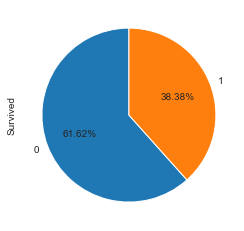

In [5]:
#绘制存活的比例

train_data['Survived'].value_counts().plot.pie(labeldistance = 1.1,autopct = '%1.2f%%',shadow = False,startangle = 90,pctdistance = 0.6)

### 2：缺失值处理

In [6]:
# 处理Embarked特征

train_data['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [7]:
train_data['Embarked'] = train_data['Embarked'].fillna('S')

In [8]:
# 处理Cabin特征

train_data['Cabin'] = train_data['Cabin'].fillna('U0')

In [9]:
# 处理Age特征，在此使用随机森林

age_df = train_data[['Age','Survived','Pclass','SibSp','Parch']]
age_df_notnull = age_df.loc[(train_data['Age'].notnull())]
age_df_isnull = age_df.loc[(train_data['Age'].isnull())]

X = age_df_notnull.values[:,1:]
Y = age_df_notnull.values[:,0]

#调用随机森林模型
from sklearn.ensemble import RandomForestRegressor

RF = RandomForestRegressor(n_estimators = 1000,n_jobs = -1)
RF.fit(X,Y)
PredictAges = RF.predict(age_df_isnull.values[:,1:])
train_data.loc[train_data['Age'].isnull(),['Age']] = PredictAges

In [10]:
#查看填充后的train_data

train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          891 non-null object
Embarked       891 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


### 3：分析数据之间的关系

####  3.1 分析性别与生存的关系

In [11]:
train_data.groupby(['Sex','Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

In [12]:
#查看不同性别的生存比例

train_data.groupby('Sex')['Survived'].mean()

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

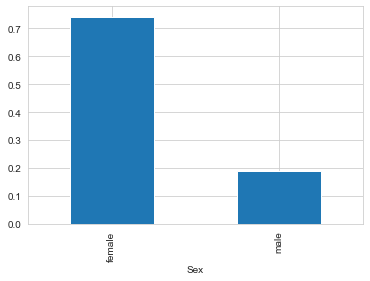

In [13]:
#可视化过程

train_data.groupby('Sex')['Survived'].mean().plot.bar()

从上述比例图中可以看出，女性的生还比例远高于男性，体现了Lady-first的原则。

#### 3.2 观察船舱等级与生存比例之间的关系

In [14]:
train_data.groupby('Pclass')['Survived'].count()

Pclass
1    216
2    184
3    491
Name: Survived, dtype: int64

In [15]:
train_data.groupby('Pclass')['Survived'].mean()

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

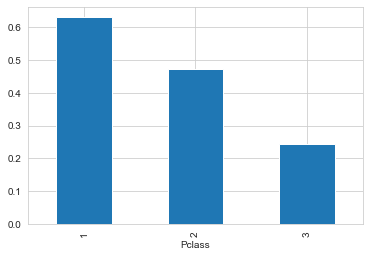

In [16]:
#可视化

train_data.groupby('Pclass')['Survived'].mean().plot(kind = 'bar')

In [17]:
sns.set_style('whitegrid')

不同等级船舱，男女的生存率

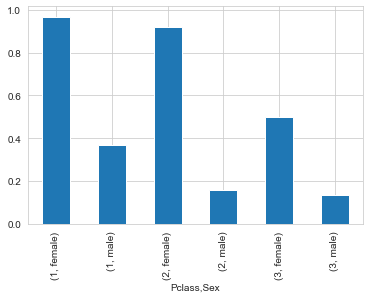

In [18]:
train_data.groupby(['Pclass','Sex'])['Survived'].mean().plot(kind = 'bar')

In [19]:
train_data.groupby(['Pclass','Sex'])['Survived'].mean()

Pclass  Sex   
1       female    0.968085
        male      0.368852
2       female    0.921053
        male      0.157407
3       female    0.500000
        male      0.135447
Name: Survived, dtype: float64

从图和表中可以看出，女性的生还比例高于男性，船舱等级越高，生还比例越高。

#### 3.3 观察年龄与生存比例之间的关系

Text(0.5, 1.0, 'Sex and Age vs Survived')

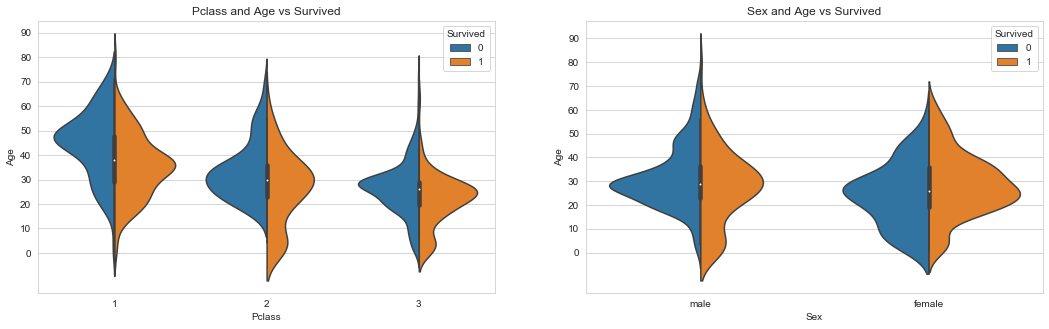

In [20]:
fig,ax = plt.subplots(1,2,figsize = (18,5))
ax[0].set_yticks(range(0,110,10))
sns.violinplot(x = 'Pclass',y = 'Age',hue = 'Survived',data = train_data,split = True,ax = ax[0])
ax[0].set_title('Pclass and Age vs Survived')

ax[1].set_yticks(range(0,110,10))
sns.violinplot(x = 'Sex',y = 'Age',hue = 'Survived',data = train_data,split = True,ax = ax[1])
ax[1].set_title('Sex and Age vs Survived')

分析年龄的总体分布

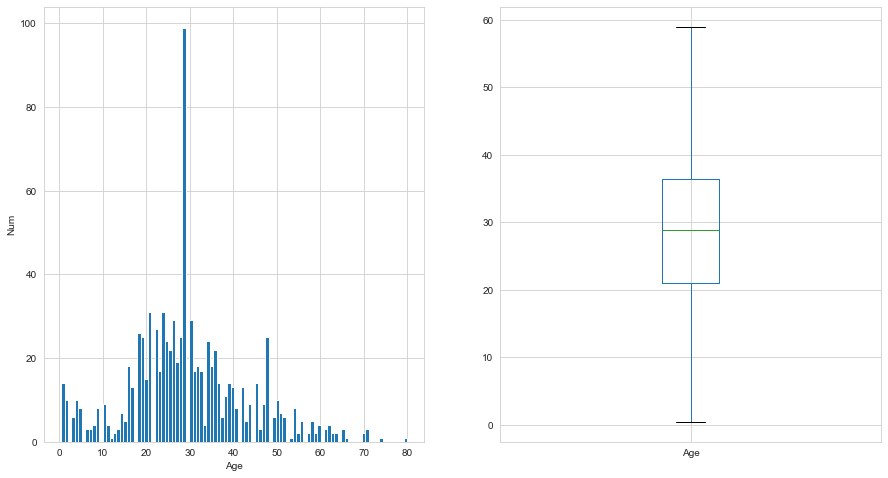

In [21]:
plt.figure(figsize = (15,8))
plt.subplot(1,2,1)
train_data['Age'].hist(bins = 100)
plt.xlabel('Age')
plt.ylabel('Num')

plt.subplot(1,2,2)
train_data.boxplot(column = 'Age',showfliers = False)

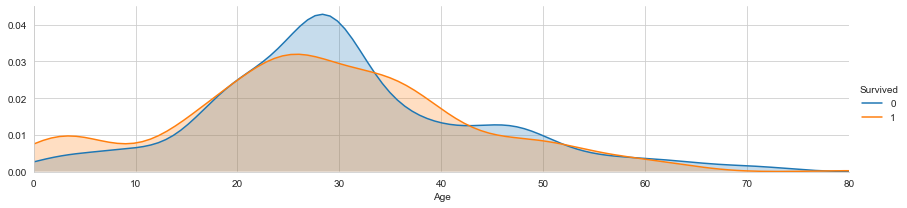

In [22]:
facet = sns.FacetGrid(train_data,hue = 'Survived',aspect = 4)
facet.map(sns.kdeplot,'Age',shade = True)
facet.set(xlim=(0,train_data['Age'].max()))
facet.add_legend()

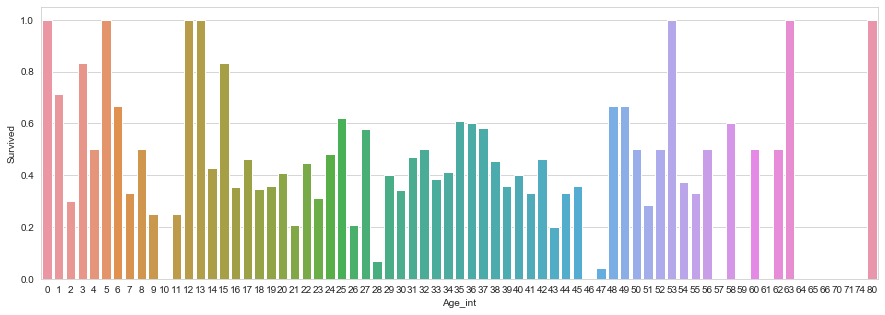

In [23]:
plt.figure(figsize = (15,5))
train_data['Age_int'] = train_data['Age'].astype(np.int)
average_age = train_data[['Age_int','Survived']].groupby('Age_int',as_index = False).mean()
sns.barplot(x = 'Age_int',y = 'Survived',data = average_age)

In [24]:
print(train_data['Age'].describe())

count    891.000000
mean      29.557118
std       13.565676
min        0.420000
25%       21.000000
50%       28.923902
75%       36.502120
max       80.000000
Name: Age, dtype: float64


该数据集有891个样本，乘客的平均年龄是29.6岁，标准差是13.6岁，最小年龄为0.42岁，最大年龄是80岁。

In [25]:
#对年龄进行分组

bins = [0,12,18,65,100]
labels = ['child','teenager','adult','older']

train_data['Age_group'] = pd.cut(train_data['Age'],bins = bins,labels = labels)

by_age = train_data.groupby('Age_group')['Survived'].mean()

print(by_age)

Age_group
child       0.500000
teenager    0.459459
adult       0.366255
older       0.125000
Name: Survived, dtype: float64


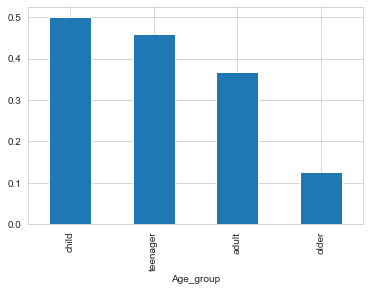

In [26]:
by_age.plot(kind = 'bar')

从上图以及数据统计中可以看出，孩子的存活率的是最高的，其比例为0.5。

#### 3.4 有无兄弟姐妹和存活的关系

In [27]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_int,Age_group
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,U0,S,22,adult
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,38,adult
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,U0,S,26,adult
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,35,adult
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,U0,S,35,adult


In [28]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Age_int
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.557118,0.523008,0.381594,32.204208,29.401796
std,257.353842,0.486592,0.836071,13.565676,1.102743,0.806057,49.693429,13.577499
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,21.000000,0.000000,0.000000,7.910400,21.000000
50%,446.000000,0.000000,3.000000,28.923902,0.000000,0.000000,14.454200,28.000000
75%,668.500000,1.000000,3.000000,36.502120,1.000000,0.000000,31.000000,36.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,80.000000


In [29]:
#将数据分为两组，有兄弟姐妹和没有兄弟姐妹

sibsp_df = train_data[train_data['SibSp'] != 0]
no_sibsp_df = train_data[train_data['SibSp'] == 0]

print('有兄弟姐妹的存活关系：')
print(sibsp_df['Survived'].value_counts(normalize = True))
print('没有兄弟姐妹的存活关系:')
print(no_sibsp_df['Survived'].value_counts(normalize = True))

有兄弟姐妹的存活关系：
0    0.533569
1    0.466431
Name: Survived, dtype: float64
没有兄弟姐妹的存活关系:
0    0.654605
1    0.345395
Name: Survived, dtype: float64


Text(0.5, 0, 'no_sibsp')

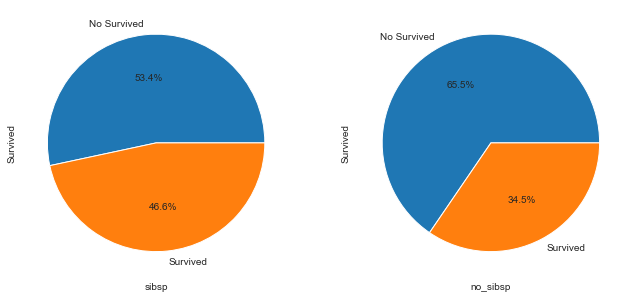

In [30]:
#数据可视化

plt.figure(figsize = (11,5))
plt.subplot(1,2,1)
sibsp_df['Survived'].value_counts().plot.pie(labels = ['No Survived','Survived'],autopct = '%1.1f%%')
plt.xlabel('sibsp')

plt.subplot(1,2,2)
no_sibsp_df['Survived'].value_counts().plot.pie(labels = ['No Survived','Survived'],autopct = '%1.1f%%')
plt.xlabel('no_sibsp')

#### 3.5 有无父母子女和存活率的关系

Text(0.5, 0, 'no_parch')

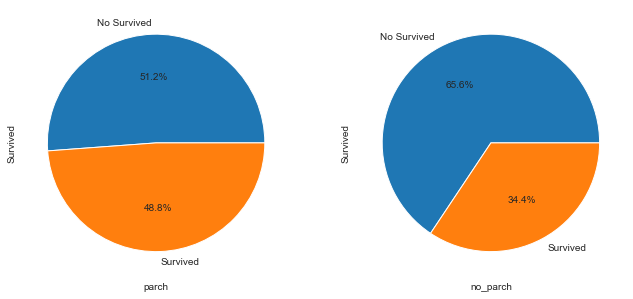

In [31]:
#将数据分为两组，有父母子女和没有父母子女的一组

parch_df = train_data[train_data['Parch'] != 0]
no_parch_df = train_data[train_data['Parch'] == 0]

#对数据结果进行可视化展示
plt.figure(figsize = (11,5))
plt.subplot(1,2,1)
parch_df['Survived'].value_counts().plot.pie(labels = ['No Survived','Survived'],autopct = '%1.1f%%')
plt.xlabel('parch')

plt.subplot(1,2,2)
no_parch_df['Survived'].value_counts().plot.pie(labels = ['No Survived','Survived'],autopct = '%1.1f%%')
plt.xlabel('no_parch')

#### 3.6 亲友人数和存活的关系

Text(0.5, 0, 'sibsp')

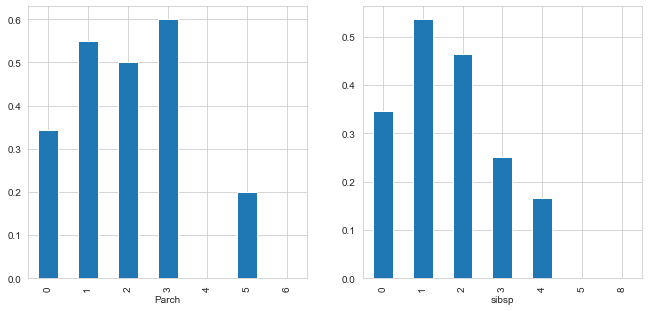

In [32]:
fig,ax = plt.subplots(1,2,figsize = (11,5))

train_data[['Parch','Survived']].groupby('Parch')['Survived'].mean().plot.bar(ax = ax[0])
plt.xlabel('parch')


train_data[['SibSp','Survived']].groupby('SibSp')['Survived'].mean().plot.bar(ax = ax[1])
plt.xlabel('sibsp')

Text(0, 0.5, 'survived ration')

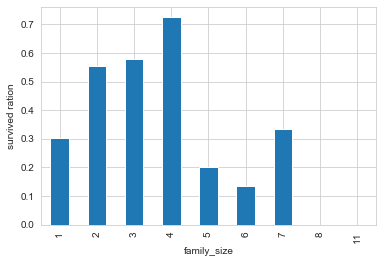

In [33]:
#创建一个亲友人数的特征

train_data['family_size'] = train_data['Parch'] + train_data['SibSp'] + 1

train_data[['family_size','Survived']].groupby('family_size')['Survived'].mean().plot.bar()
plt.xlabel('family_size')
plt.ylabel('survived ration')

由上图可以看出，自己一个人的时候，存活率是比较低的；家庭成员比较多的时候，存活率也是比较低的。

#### 3.7 票价分布和存活的关系

Text(0, 0.5, 'Frequency')

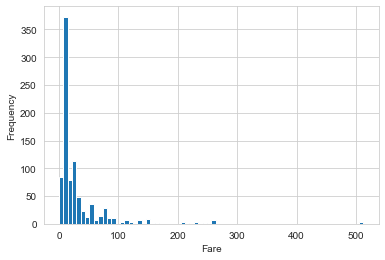

In [34]:
#首先查看票价的分布

plt.figure(figsize = (6,4))
train_data['Fare'].hist(bins = 70)
plt.xlabel('Fare')
plt.ylabel('Frequency')

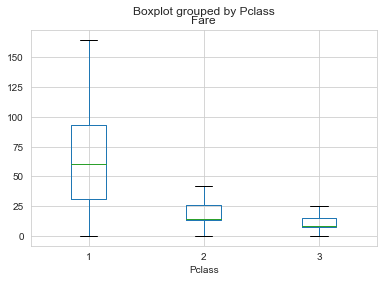

In [35]:
train_data.boxplot(column = 'Fare',by = 'Pclass',showfliers = False)

In [36]:
train_data['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

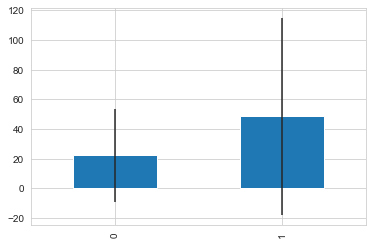

In [37]:
#观察票价的均值，标准差与生存的关系

fare_not_survived = train_data[train_data['Survived'] == 0]['Fare']
fare_survived = train_data[train_data['Survived'] == 1]['Fare']

avg_fare = pd.DataFrame([fare_not_survived.mean(),fare_survived.mean()])
std_fare = pd.DataFrame([fare_not_survived.std(),fare_survived.std()])


avg_fare.plot(yerr = std_fare, kind = 'bar',legend = False)

由图可知，票价与是否生还是存在一定的相关性的，高票价对应的生还率也相应的高。

#### 3.8 登陆港口与存活的关系

泰坦尼克号从英国南安普顿出发，途径发过瑟堡和爱尔兰昆士敦，在昆士敦之前上船的人，有可能在瑟堡和昆士敦下船，这些乘客将不会遭遇沉船事故。

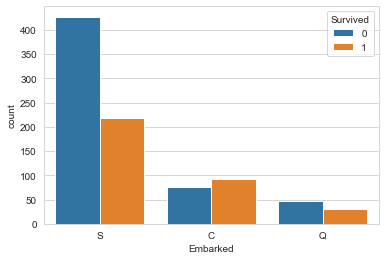

In [38]:
sns.countplot(x = 'Embarked',hue = 'Survived',data = train_data)

Text(0.5, 1, 'Embarked and Survived Rate')

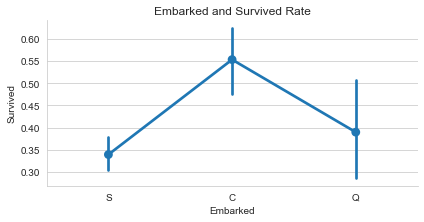

In [39]:
sns.factorplot('Embarked','Survived',data = train_data,size = 3,aspect = 2)
plt.title('Embarked and Survived Rate')

从上图可以看出，C港口的乘客存活率是最高的，其次是Q港口，最低的是S港口。据了解，泰坦尼克号上共有2224名乘客，本数据集选取了其中的891名乘客信息作为样本数据。如果这891个样本是随机选择的，根据中心极限定理，其数量足够，所以该分析结果具有代表性；如果这891条样本数据不是随机选取的，那么该结果就不是特别的靠谱。

### 4.变量转换

**4.1 登陆港口数据类型转换**

In [40]:
embark_dummies = pd.get_dummies(train_data['Embarked'])
train_data = pd.concat([train_data,embark_dummies],axis = 1)
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_int,Age_group,family_size,C,Q,S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,U0,S,22,adult,2,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,38,adult,2,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,U0,S,26,adult,1,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,35,adult,2,0,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,U0,S,35,adult,1,0,0,1


In [41]:
train_data[['C','Q','S']].head()

,C,Q,S
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1


**4.2 船舱编号数据类型转换**

In [42]:
train_data['Cabin'][train_data.Cabin.isnull()] = 'U0'

train_data['Cabinletter'] = train_data['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())

train_data['Cabinletter'] = pd.factorize(train_data['Cabinletter'])[0]

train_data[['Cabin','Cabinletter']].head()

,Cabin,Cabinletter
0,U0,0
1,C85,1
2,U0,0
3,C123,1
4,U0,0


**4.3 对Age特征进行数据处理**

In [43]:
from sklearn.preprocessing import StandardScaler

train_data['norm_age'] = StandardScaler().fit_transform(train_data[['Age']])

train_data['norm_age'].head()

0   -0.557389
1    0.622720
2   -0.262362
3    0.401450
4    0.401450
Name: norm_age, dtype: float64

**4.4 对Fare特征进行处理**

In [44]:
train_data['fare_bin'] = pd.qcut(train_data['Fare'],5)
print(train_data['fare_bin'].head())

0      (-0.001, 7.854]
1    (39.688, 512.329]
2        (7.854, 10.5]
3    (39.688, 512.329]
4        (7.854, 10.5]
Name: fare_bin, dtype: category
Categories (5, interval[float64]): [(-0.001, 7.854] < (7.854, 10.5] < (10.5, 21.679] < (21.679, 39.688] < (39.688, 512.329]]


In [45]:
fare_dummies = pd.get_dummies(train_data['fare_bin'],prefix = 'fare')
train_data = pd.concat([train_data,fare_dummies],axis = 1)

train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Q,S,Cabinletter,norm_age,fare_bin,"fare_(-0.001, 7.854]","fare_(7.854, 10.5]","fare_(10.5, 21.679]","fare_(21.679, 39.688]","fare_(39.688, 512.329]"
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0,1,0,-0.557389,"(-0.001, 7.854]",1,0,0,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,0,0,1,0.622720,"(39.688, 512.329]",0,0,0,0,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,0,1,0,-0.262362,"(7.854, 10.5]",0,1,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,0,1,1,0.401450,"(39.688, 512.329]",0,0,0,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,0,1,0,0.401450,"(7.854, 10.5]",0,1,0,0,0


### 5.特征工程

In [46]:
#观察训练数据集和测试数据集

train_data = pd.read_csv('D:\\Py_dataset\\train.csv')
test_data = pd.read_csv('D:\\Py_dataset\\test.csv')

print('训练集大小:',train_data.shape)
print('测试集大小:',test_data.shape)

训练集大小: (891, 12)
测试集大小: (418, 11)


In [47]:
#往测试集增加survived特征

test_data['Survived'] = 0

#将训练集和测试集合并

full_data = pd.concat([train_data,test_data],axis = 0)

print('完整数据集的大小:',full_data.shape)

完整数据集的大小: (1309, 12)


对数据集进行特征工程，也就是从给定的特征中提取出对结果有或大或小影响的特征，将这些特征作为模型训练的依据。一般来说，我们会先从含有缺失值的特征开始。

#### 5.1 Emabarked

In [48]:
full_data['Embarked'].value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

In [49]:
full_data['Embarked'] = full_data['Embarked'].fillna('S')

In [50]:
full_data['Embarked'].isnull().sum()

0

In [51]:
#对Embarked特征进行dummies编码

Embarked = pd.get_dummies(full_data['Embarked'])
full_data = pd.concat([full_data,Embarked],axis = 1)

#### 5.2 Sex 

In [52]:
#对Sex特征进行one_hot编码

Sex = pd.get_dummies(full_data['Sex'])

full_data = pd.concat([full_data,Sex],axis = 1)

#### 5.3 Fare

In [53]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 17 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1309 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       1309 non-null int64
Ticket         1309 non-null object
C              1309 non-null uint8
Q              1309 non-null uint8
S              1309 non-null uint8
female         1309 non-null uint8
male           1309 non-null uint8
dtypes: float64(2), int64(5), object(5), uint8(5)
memory usage: 139.3+ KB


In [54]:
full_data['Fare'] = full_data['Fare'].fillna(full_data['Fare'].mean())

In [55]:
full_data['Ticket'].nunique()

929

由ticket的数量可以得知，船票是存在重复的。由前面的数据分析知道，其中存在亲人家属关系，所以部分票为团体票。这就需要我们将团体票的票价平分到每一个人。

In [56]:
full_data['group_ticket'] = full_data['Fare'].groupby(full_data['Ticket']).transform('count')

full_data['group_ticket'].shape

(1309,)

In [57]:
#乘客的平均票价

full_data['Fare'] = full_data['Fare'] / full_data['group_ticket']

full_data = full_data.drop('group_ticket',axis = 1)

In [58]:
# 使用bin给票价分等级
full_data['fare_bin'] = pd.qcut(full_data['Fare'],5)

# 对fare_bin进行dummies编码
fare_bin = pd.get_dummies(full_data['fare_bin'])
fare_bin.head()

   (-0.001, 7.229]  (7.229, 7.896]  (7.896, 10.5]  (10.5, 26.277]  \
0                0               1              0               0   
1                0               0              0               0   
2                0               0              1               0   
3                0               0              0               0   
4                0               0              1               0   

   (26.277, 128.082]  
0                  0  
1                  1  
2                  0  
3                  1  
4                  0  

In [59]:
full_data = pd.concat([full_data,fare_bin],axis = 1)

#### 5.4 Parch and SibSp

由前面的分析结果可知，亲友的数量过多或过少，都会影响生存率。这里将Parch和SibSp两项合并为一项family_size。

In [60]:
full_data['family_size'] = full_data['Parch'] + full_data['SibSp'] + 1

full_data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,...,S,female,male,fare_bin,"(-0.001, 7.229]","(7.229, 7.896]","(7.896, 10.5]","(10.5, 26.277]","(26.277, 128.082]",family_size
0,22.0,NaN,S,7.25000,"Braund, Mr. Owen Harris",0,1,3,male,1,...,1,0,1,"(7.229, 7.896]",0,1,0,0,0,2
1,38.0,C85,C,35.64165,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,...,0,1,0,"(26.277, 128.082]",0,0,0,0,1,2
2,26.0,NaN,S,7.92500,"Heikkinen, Miss. Laina",0,3,3,female,0,...,1,1,0,"(7.896, 10.5]",0,0,1,0,0,1
3,35.0,C123,S,26.55000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,...,1,1,0,"(26.277, 128.082]",0,0,0,0,1,2
4,35.0,NaN,S,8.05000,"Allen, Mr. William Henry",0,5,3,male,0,...,1,0,1,"(7.896, 10.5]",0,0,1,0,0,1


In [62]:
family_map = {1:'single',
             2:'small family',
             3:'small family',
             4:'small family',
             5:'large family',
             6:'large family',
             7:'large family',
             8:'large family',
             11:'large family'}
full_data['family_size_category'] = full_data['family_size'].map(family_map)

In [63]:
full_data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,...,female,male,fare_bin,"(-0.001, 7.229]","(7.229, 7.896]","(7.896, 10.5]","(10.5, 26.277]","(26.277, 128.082]",family_size,family_size_category
0,22.0,NaN,S,7.25000,"Braund, Mr. Owen Harris",0,1,3,male,1,...,0,1,"(7.229, 7.896]",0,1,0,0,0,2,small family
1,38.0,C85,C,35.64165,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,...,1,0,"(26.277, 128.082]",0,0,0,0,1,2,small family
2,26.0,NaN,S,7.92500,"Heikkinen, Miss. Laina",0,3,3,female,0,...,1,0,"(7.896, 10.5]",0,0,1,0,0,1,single
3,35.0,C123,S,26.55000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,...,1,0,"(26.277, 128.082]",0,0,0,0,1,2,small family
4,35.0,NaN,S,8.05000,"Allen, Mr. William Henry",0,5,3,male,0,...,0,1,"(7.896, 10.5]",0,0,1,0,0,1,single


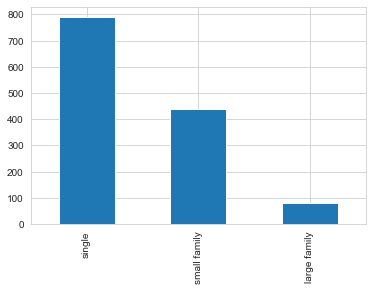

In [64]:
full_data['family_size_category'].value_counts().plot(kind = 'bar')

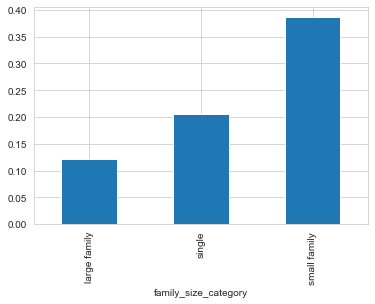

In [65]:
full_data.groupby('family_size_category')['Survived'].mean().plot(kind = 'bar')

#### 5.5 Age

In [66]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 25 columns):
Age                     1046 non-null float64
Cabin                   295 non-null object
Embarked                1309 non-null object
Fare                    1309 non-null float64
Name                    1309 non-null object
Parch                   1309 non-null int64
PassengerId             1309 non-null int64
Pclass                  1309 non-null int64
Sex                     1309 non-null object
SibSp                   1309 non-null int64
Survived                1309 non-null int64
Ticket                  1309 non-null object
C                       1309 non-null uint8
Q                       1309 non-null uint8
S                       1309 non-null uint8
female                  1309 non-null uint8
male                    1309 non-null uint8
fare_bin                1309 non-null category
(-0.001, 7.229]         1309 non-null uint8
(7.229, 7.896]          1309 non-null uint8
(7.

In [67]:
full_data = full_data.fillna(full_data['Embarked'].mode())
print(full_data['Embarked'].isnull().sum())

0


In [76]:
age_df = full_data[['Age','Fare','Parch','Pclass','Survived','SibSp','family_size']]
age_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 7 columns):
Age            1046 non-null float64
Fare           1309 non-null float64
Parch          1309 non-null int64
Pclass         1309 non-null int64
Survived       1309 non-null int64
SibSp          1309 non-null int64
family_size    1309 non-null int64
dtypes: float64(2), int64(5)
memory usage: 81.8 KB


In [77]:
is_age_df = age_df.loc[age_df['Age'].notnull()]
no_age_df = age_df.loc[age_df['Age'].isnull()]

print(is_age_df.shape[0])
print(no_age_df.shape[0])

1046
263


In [78]:
#使用随机森林模型来预测缺失的年龄数据

from sklearn.ensemble import RandomForestRegressor

RF = RandomForestRegressor(n_estimators = 1000)
RF.fit(is_age_df.values[:,1:],is_age_df.values[:,0])
predictions = RF.predict(no_age_df.values[:,1:])

In [83]:
full_data.loc[full_data['Age'].isnull(),['Age']] = predictions

In [84]:
print(full_data['Age'].isnull().sum())

0
